# L1 Data Visualization Notebook

This Report comprises the entire Data Visualization of the L1 data (Level 1 Data) of the Hotel Recommendation System built. 

In [1]:
import boto3
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from textblob import TextBlob
from io import StringIO
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from datetime import datetime, timedelta
import colorlover as cl
import plotly.io as pio
from IPython.display import Image, display, HTML


In [2]:
# Generate a custom color palette with 15 shades of blue
cp = cl.scales['9']['seq']['Blues']
color_palette = cl.interp(cp, 15)

## Loading the dataset

First we should download the L1 CSV file from the S3 bucket and load it into a Pandas DataFrame. 

In [3]:
# Set up boto3 client
s3_client = boto3.client('s3', region_name='us-west-2')

# Define bucket and object key
bucket_name = 'andorra-hotels-data-warehouse'
object_key = 'l1_data/text/l1_data_2024-07-21_16-33-02.csv'

# Get the object from S3
response = s3_client.get_object(Bucket=bucket_name, Key=object_key)

# Read the data into a DataFrame
df = pd.read_csv(StringIO(response['Body'].read().decode('utf-8')))

# Display the first few rows of the DataFrame as a pretty table
df_head = df.head()

In [4]:
# df_head.style.hide()

## Basic data information

We will now display the dataset characteristics and information

In [5]:
# Print the total number of samples
total_samples = len(df)
print(f"Total number of samples: {total_samples}")

Total number of samples: 31875


In [6]:
# Print the total of samples by region 
# Print the total of hotels by region
# Group by 'region' and calculate the number of samples and number of unique hotels per region
region_summary = df.groupby('region').agg(
    number_of_samples=('region', 'size'),
    number_of_unique_hotels=('hotel_name', 'nunique')
).reset_index()

# Display the new dataframe
region_summary.style.hide()

region,number_of_samples,number_of_unique_hotels
Andorra la Vella,5000,50
Canillo,3879,47
Encamp,4178,50
Escaldes-Engordany,4792,49
La Massana,4557,49
Ordino,4836,50
Sant Julià de Lòria,4633,50


## 1. Distribution of Ratings

### 1.1. Histogram of Ratings

Visualize the distribution of Hotel ratings

In [7]:
# Assuming df is already defined
# Plot histogram of ratings with Plotly
hist_data = df['rating'].value_counts().sort_index()
fig_hist = go.Figure(data=[go.Bar(
        x=hist_data.index,
        y=hist_data.values,
        marker_color='#636EFA'  # Example color
    )])
fig_hist.update_layout(
    title_x=0.5,
    xaxis_title='Rating',
    yaxis_title='Frequency',
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
    font=dict(
        family="Arial, sans-serif",
        size=16,
        color="#000000"
    ),
    height=400,  # Adjust the height as needed
    width=600   # Adjust the width as needed
)

# Define the bins and labels
bins = [2, 2.5, 3, 3.5, 4, 4.5, 5]
labels = ['2-2.5', '2.6-3', '3.1-3.5', '3.6-4', '4.1-4.5', '4.6-5']

# Create a new column for the binned ratings
df['rating_bin'] = pd.cut(df['rating'], bins=bins, labels=labels, include_lowest=True)

# Create a table with the binned ratings and their frequencies
ratings_count = df['rating_bin'].value_counts().reset_index()
ratings_count.columns = ['Rating Range', 'Number of Ratings']
ratings_count = ratings_count.sort_values('Rating Range')

# Save the histogram as a static image with transparent background
pio.write_image(fig_hist, '../plots/1_1_histogram.png', scale=2, format='png', engine='kaleido')

# Define the HTML template to display the image and the table side by side
html_template = '''
<div style="display: flex; align-items: center;">
    <div style="flex: 1;">
        <img src="{img_path}" width="{img_width}" height="{img_height}">
    </div>
    <div style="flex: 1; padding-left: 20px;">
        {table}
    </div>
</div>
'''

# Generate the HTML content
html_content = html_template.format(
    img_path='../plots/1_1_histogram.png',
    img_width=800,  # Adjust the width and height as needed
    img_height=400,
    table=ratings_count.to_html(index=False)
)

# Display the content
display(HTML(html_content))

Rating Range,Number of Ratings
2-2.5,104
2.6-3,105
3.1-3.5,1126
3.6-4,8915
4.1-4.5,18192
4.6-5,3433


### 1.2. Average Rating per region

Bar chart showing the average rating of hotels in each region.

In [8]:
# Calculate average rating per region
avg_rating_per_region = df.groupby('region')['rating'].mean().sort_values()

# Plot average rating per region with Plotly
fig_avg_rating = go.Figure(data=[go.Bar(
    x=avg_rating_per_region.index,
    y=avg_rating_per_region.values,
    marker_color=color_palette[5:]
)])

fig_avg_rating.update_layout(
    # title_text='Average Hotel Rating per Region',
    title_x=0.5,
    xaxis_title='Region',
    yaxis_title='Average Rating',
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
    font=dict(
        family="Arial, sans-serif",
        size=12,
        color="#000000"
    ),
    xaxis_tickangle=-45
)

# Save the figure as a static image with transparent background
pio.write_image(fig_hist, '../plots/1_2_plot.png', scale=2, format='png', engine='kaleido')

# Create a table with the average ratings per region
avg_rating_df = avg_rating_per_region.reset_index()
avg_rating_df.columns = ['Region', 'Average Rating']

# Define the HTML template to display the image and the table side by side
html_template = '''
<div style="display: flex; align-items: center;">
    <div style="flex: 1;">
        <img src="{img_path}" width="{img_width}" height="{img_height}">
    </div>
    <div style="flex: 1; padding-left: 20px;">
        {table}
    </div>
</div>
'''

# Generate the HTML content
html_content = html_template.format(
    img_path='../plots/1_2_plot.png',
    img_width=800,  # Adjust the width and height as needed
    img_height=400,
    table=avg_rating_df.to_html(index=False)
)

# Display the content
display(HTML(html_content))

Region,Average Rating
Sant Julià de Lòria,4.068034
Andorra la Vella,4.110000
Escaldes-Engordany,4.145075
Encamp,4.220393
Ordino,4.247353
La Massana,4.257735
Canillo,4.309229


## 2. Reviews Analysis

### 2.1. Number of Reviews per hotel

Bar chart showing the total number of reviews for each hotel.

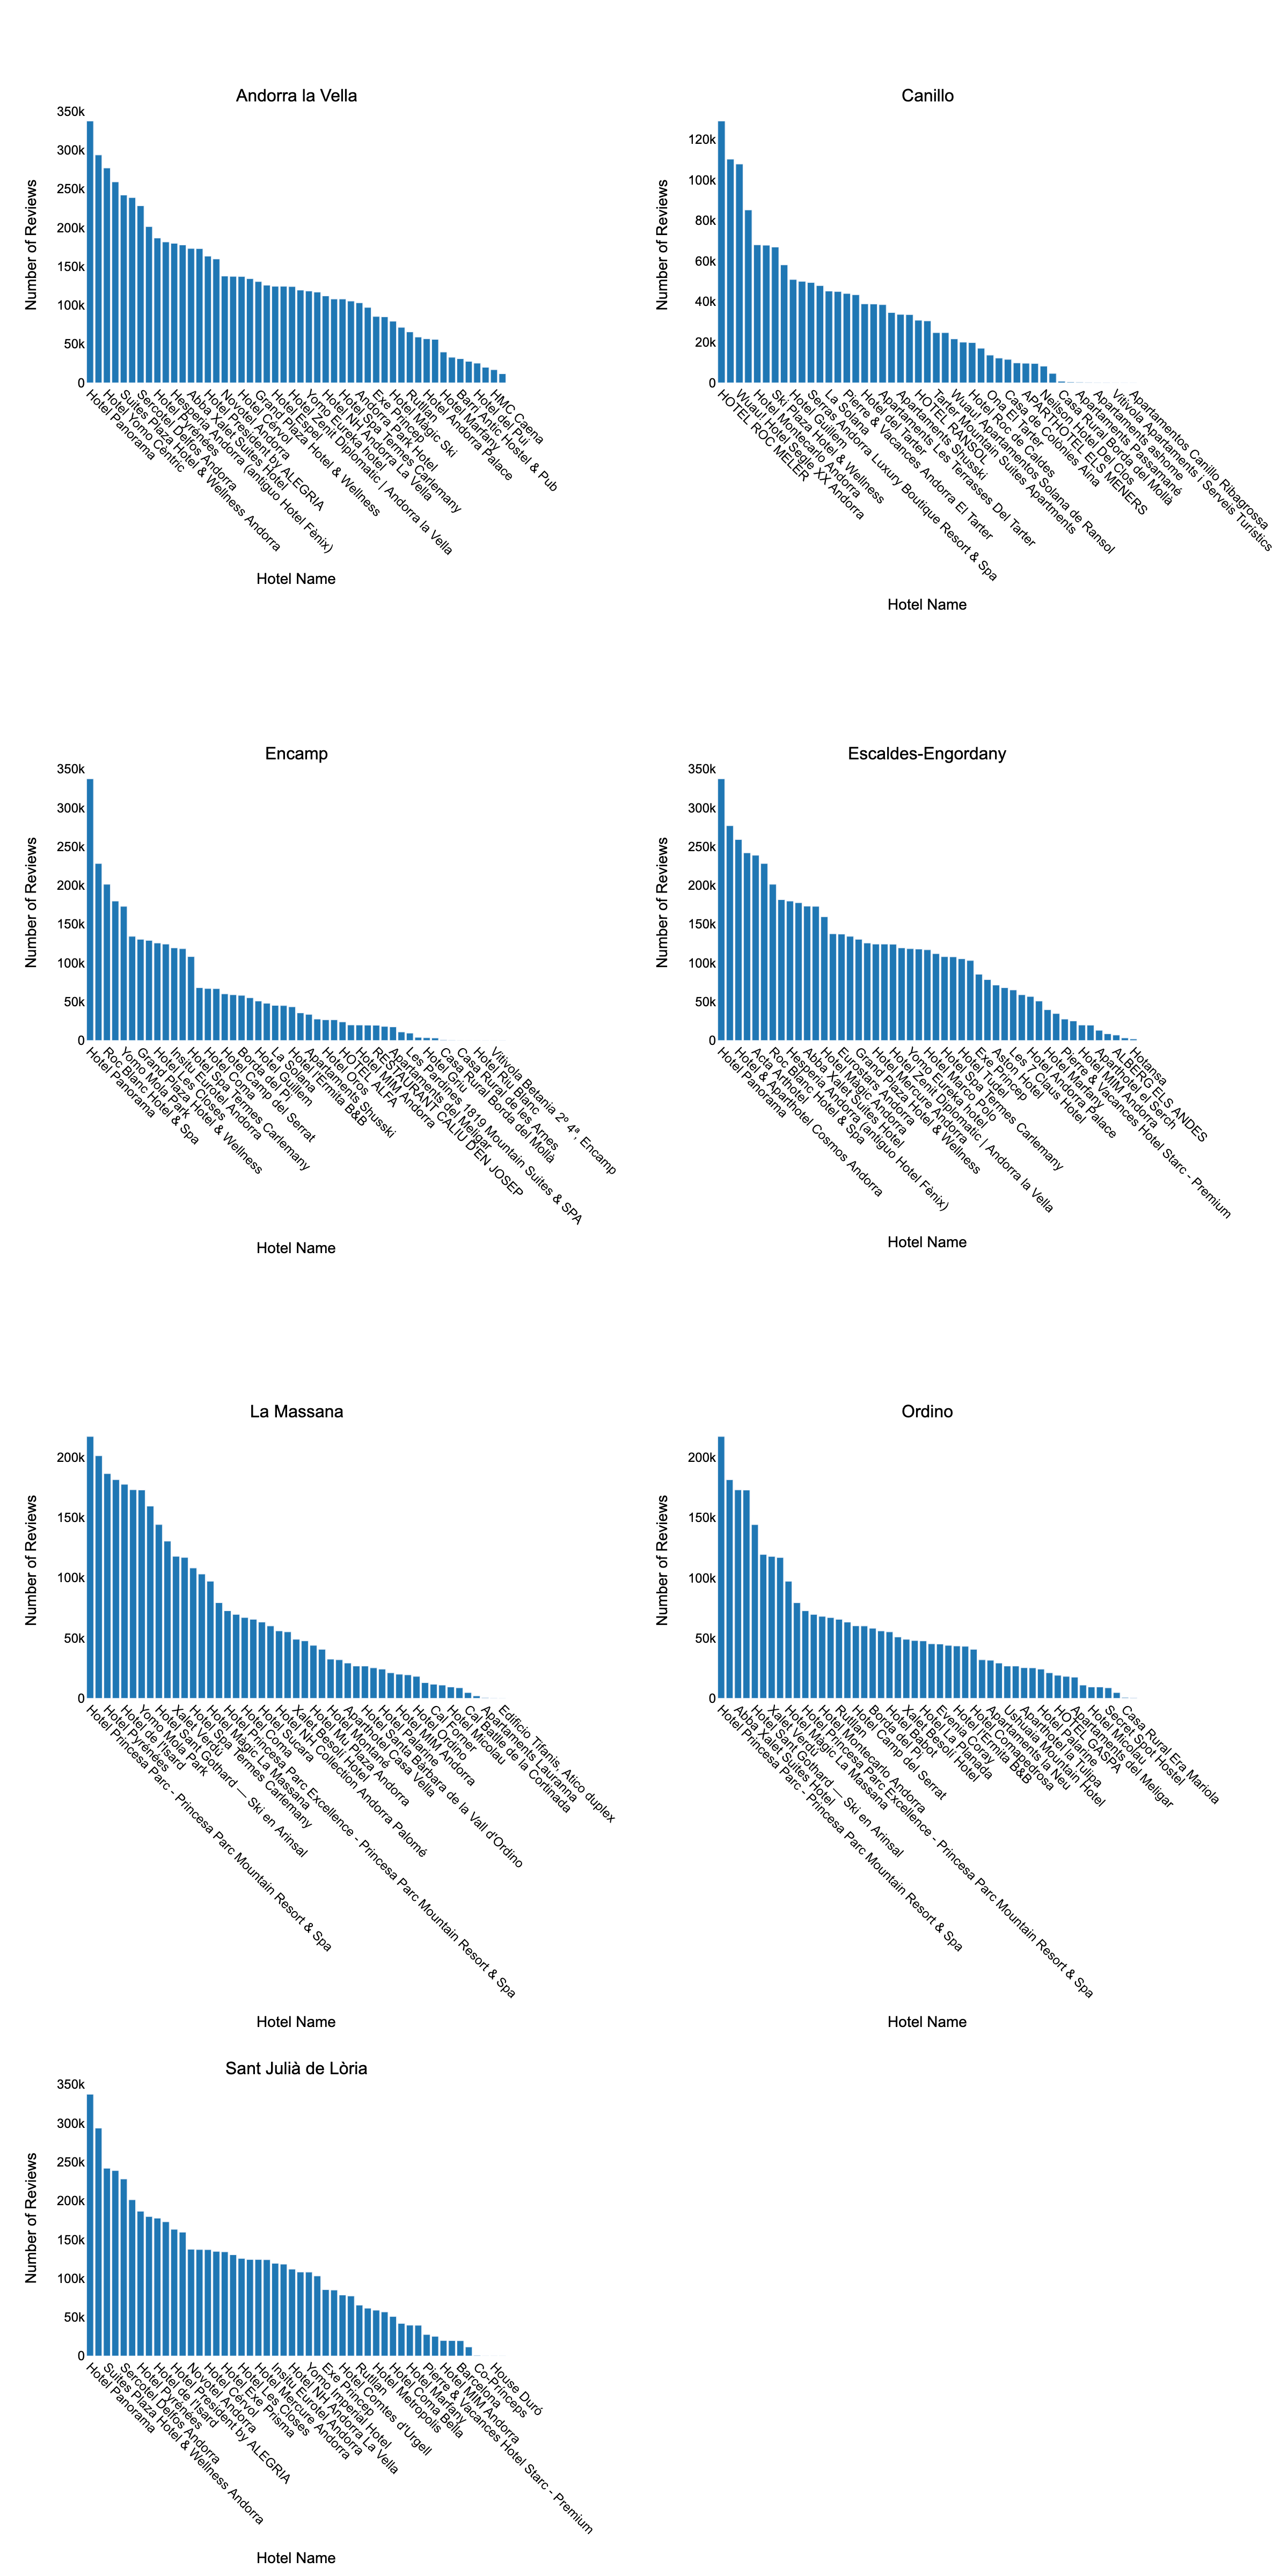

Region,Average Number of Ratings
Andorra la Vella,1279.140000
Canillo,401.311936
Encamp,741.258018
Escaldes-Engordany,1170.498539
La Massana,744.312706
Ordino,602.032051
Sant Julià de Lòria,1170.644723


In [9]:
# Create a table with the average number of ratings per region
avg_ratings_per_region = df.groupby('region')['user_ratings_total'].mean().reset_index()
avg_ratings_per_region.columns = ['Region', 'Average Number of Ratings']

#  Get the list of regions
regions = df['region'].unique()

# Create subplots with adjusted spacing
fig = make_subplots(rows=4, cols=2, subplot_titles=regions, horizontal_spacing=0.2, vertical_spacing=0.17)

# Plot the number of reviews per hotel for each region using user_ratings_total
for i, region in enumerate(regions):
    region_df = df[df['region'] == region]
    reviews_per_hotel = region_df.groupby('hotel_name')['user_ratings_total'].sum().sort_values(ascending=False)
    
    row = i // 2 + 1
    col = i % 2 + 1
    
    fig.add_trace(
        go.Bar(
            x=reviews_per_hotel.index,
            y=reviews_per_hotel.values,
            marker_color='#1f77b4',
            name=region
        ),
        row=row, col=col
    )
    
    fig.update_xaxes(title_text='Hotel Name', row=row, col=col, tickangle=45)
    fig.update_yaxes(title_text='Number of Reviews', row=row, col=col)

# Update layout
fig.update_layout(
    height=2400, width=1200,
    # title_text='Number of Reviews per Hotel by Region',
    showlegend=False,
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
    font=dict(
        family="Arial, sans-serif",
        size=12,
        color="#000000"
    )
)

# Save the figure as a static image with transparent background
pio.write_image(fig, '../plots/2_1_plot.png', scale=2, format='png', engine='kaleido')

# Optionally, display the static images
display(Image(filename='../plots/2_1_plot.png', width=800, height=600))
avg_ratings_per_region.style.hide()

### 2.2. Review Count Comparison

Bar chart comparing the number of reviews between regions.

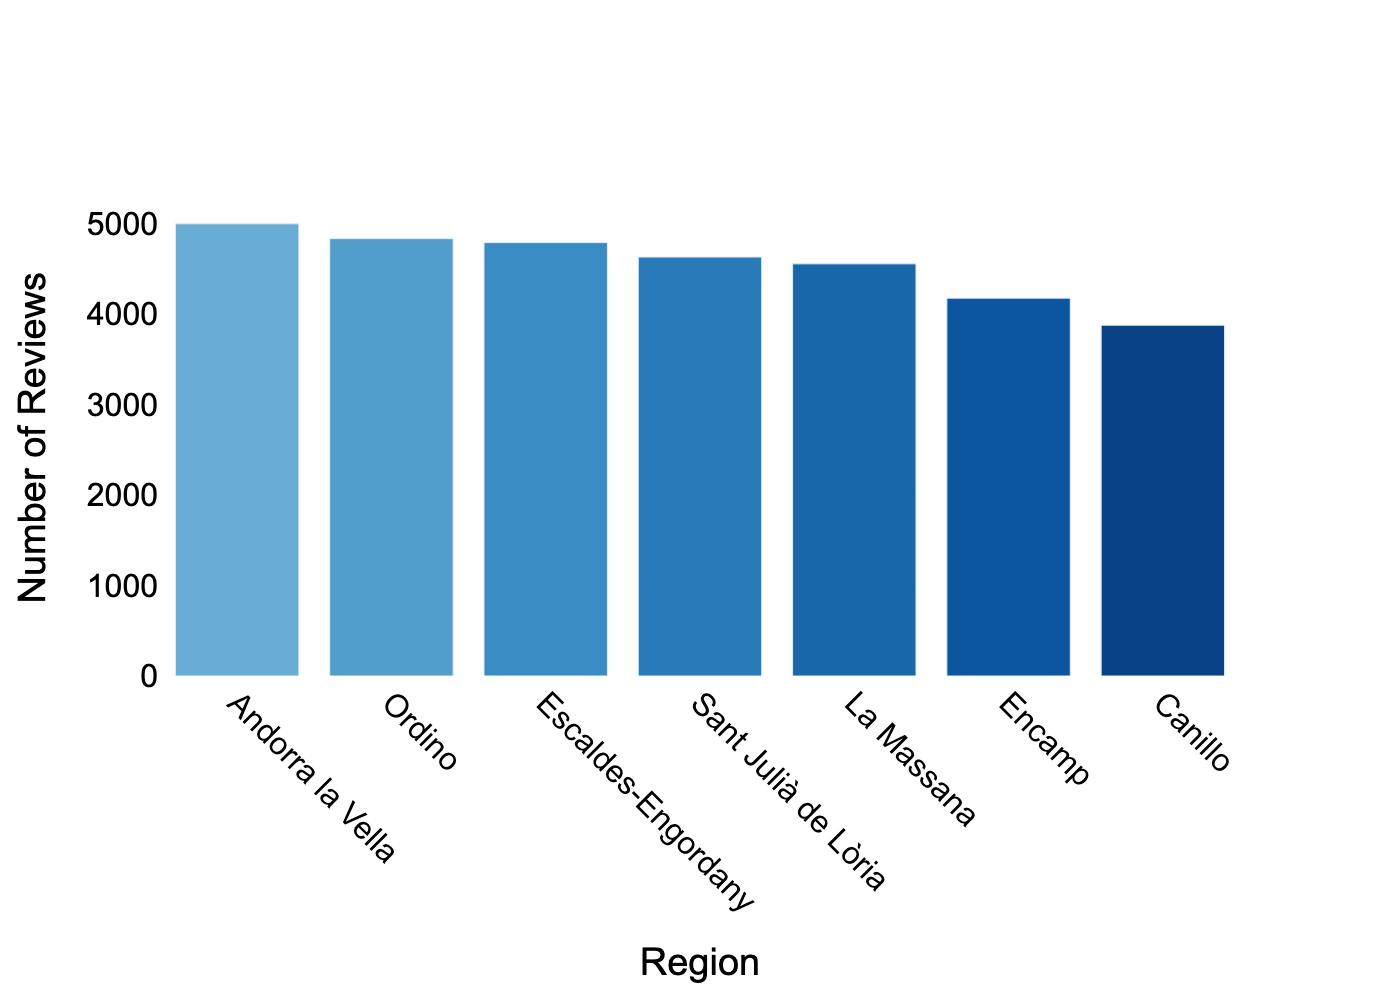

In [10]:
# Calculate review count per region
review_count_region = df['region'].value_counts()

# Create a bar chart with Plotly
fig_bar = go.Figure()

fig_bar.add_trace(go.Bar(
    x=review_count_region.index,
    y=review_count_region.values,
    marker_color=color_palette[7:],
    name='Review Count'
))

fig_bar.update_layout(
    # title_text='Review Count per Region',
    title_x=0.5,
    xaxis_title='Region',
    yaxis_title='Number of Reviews',
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
    font=dict(
        family="Arial, sans-serif",
        size=16,
        color="#000000"
    ),
    xaxis_tickangle=45
)

# Show the bar chart
# fig_bar.show()

# Save the figure as a static image with transparent background
pio.write_image(fig_bar, '../plots/2_2_plot.png', scale=2, format='png', engine='kaleido')

# Optionally, display the static images
display(Image(filename='../plots/2_2_plot.png', width=800, height=600))

### 2.2. Review count over time 

Line chart showing the number of reviews over time to identify trends.

In [18]:
# Assuming df is already defined
# Convert days to actual date
current_date = datetime(2024, 7, 20)
df['review_date'] = df['review_date_in_days'].apply(lambda x: current_date - timedelta(days=x))

# Review Count Over Time
review_count_over_time = df.groupby(df['review_date'].dt.to_period('M')).size()
review_count_over_time = review_count_over_time.to_timestamp()

# Plot review count over time with Plotly
fig_line = go.Figure()

fig_line.add_trace(go.Scatter(
    x=review_count_over_time.index,
    y=review_count_over_time.values,
    mode='lines+markers',
    marker=dict(color='#636EFA'),  # Example color
    line=dict(color='#636EFA'),    # Example color
    name='Review Count'
))

fig_line.update_layout(
    title_x=0.5,
    xaxis_title='Time',
    yaxis_title='Number of Reviews',
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
    font=dict(
        family="Arial, sans-serif",
        size=12,
        color="#000000"
    ),
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True)
)

# Save the figure as a static image with transparent background
pio.write_image(fig_line, '../plots/2_3_plot.png', scale=2, format='png', engine='kaleido')

# Define the time ranges and labels
bins = [datetime(1970, 1, 1), datetime(2016, 1, 1), datetime(2020, 1, 1), datetime(2022, 1, 1), datetime(2024, 1, 1), datetime(2025, 1, 1)]
labels = ['< 2016', '2016-2020', '2020-2022', '2022-2024', '> 2024']

# Categorize the review dates into the defined ranges
df['review_period'] = pd.cut(df['review_date'], bins=bins, labels=labels, include_lowest=True)

# Calculate the count and percentage of reviews for each category
review_counts = df['review_period'].value_counts().sort_index()
review_percentages = (review_counts / review_counts.sum()) * 100

# Create a DataFrame with the results
review_summary_df = pd.DataFrame({
    'Review Period': review_counts.index,
    'Number of Reviews': review_counts.values,
    'Percentage': review_percentages.values
})

# Define the HTML template to display the image and the table side by side
html_template = '''
<div style="display: flex; align-items: center;">
    <div style="flex: 1;">
        <img src="{img_path}" width="{img_width}" height="{img_height}">
    </div>
    <div style="flex: 1; padding-left: 20px;">
        {table}
    </div>
</div>
'''

# Generate the HTML content
html_content = html_template.format(
    img_path='../plots/2_3_plot.png',
    img_width=600,  # Adjust the width and height as needed
    img_height=400,
    table=review_summary_df.to_html(index=False)
)

# Display the content
display(HTML(html_content))

Review Period,Number of Reviews,Percentage
< 2016,538,1.687843
2016-2020,7045,22.101961
2020-2022,3589,11.259608
2022-2024,7398,23.209412
> 2024,13305,41.741176


## 3. Language Ananlysis

### 3.1 Language Distribution
Pie chart showing the distribution of review languages.

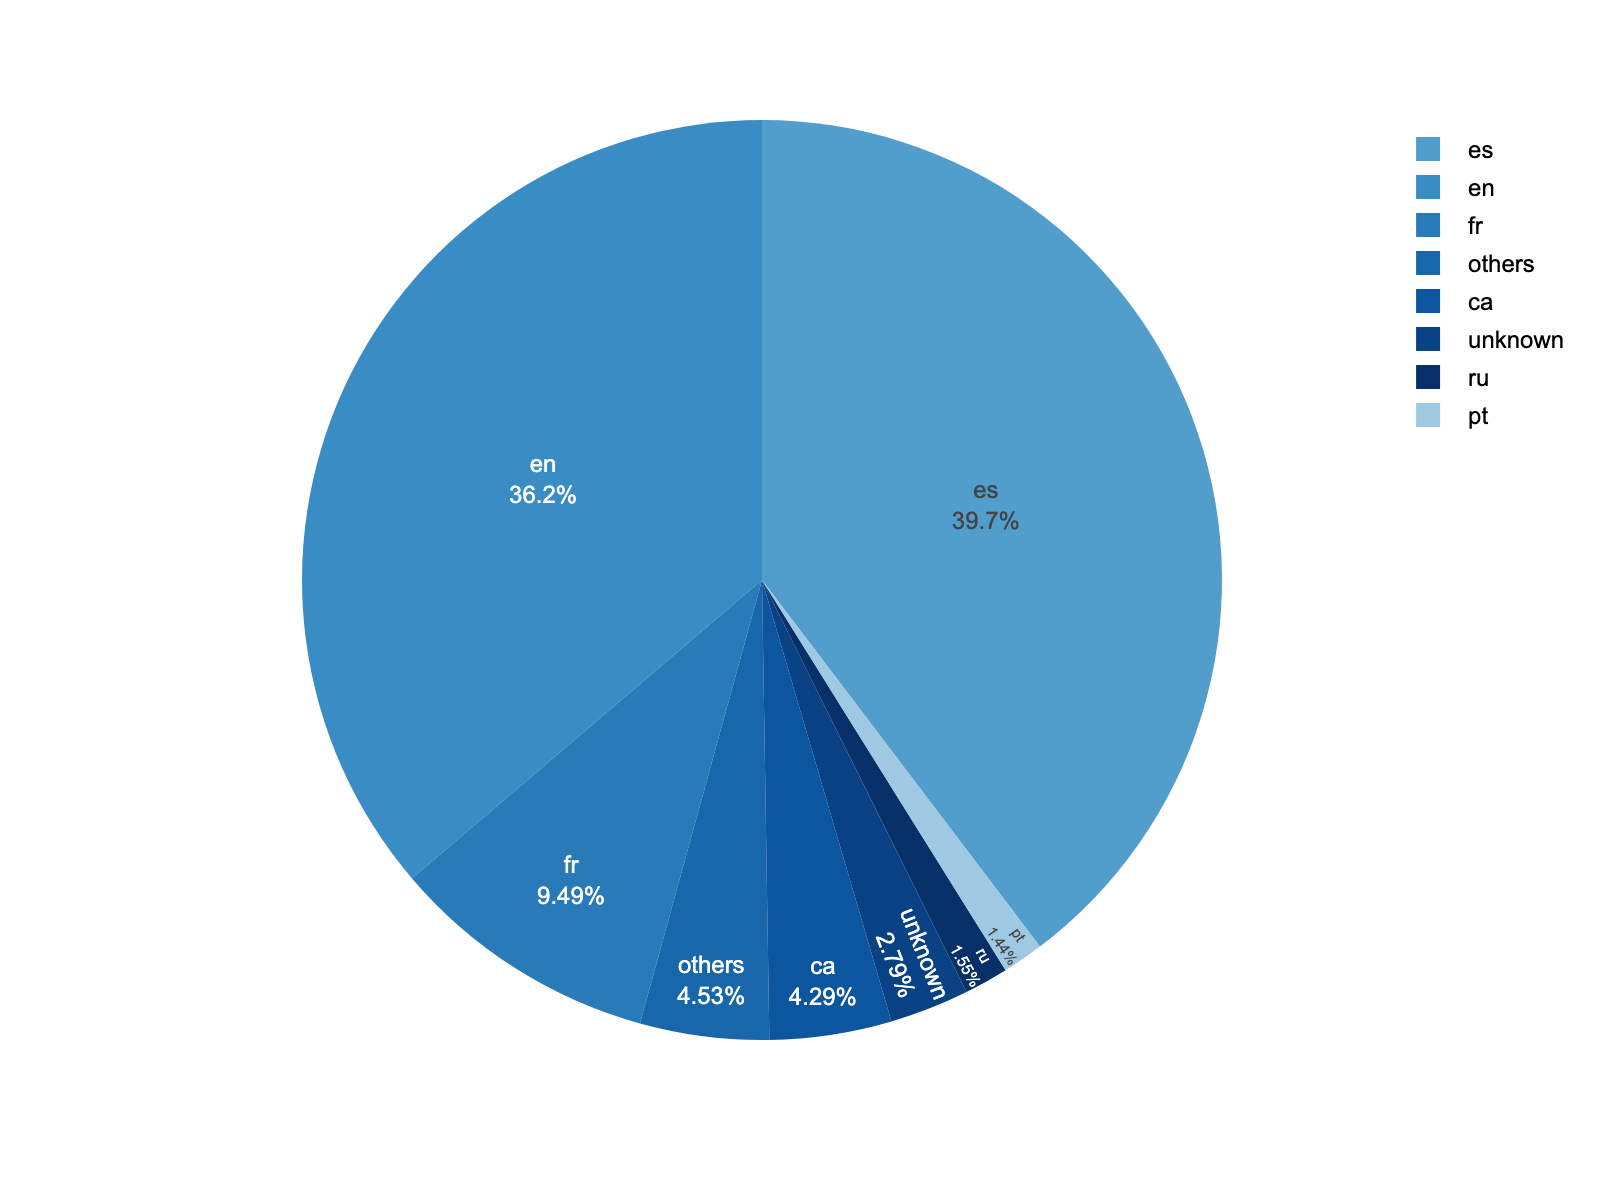

In [13]:
# Calculate language distribution
language_dist = df['review_language'].value_counts()

# Calculate the threshold for "Others"
total_reviews = language_dist.sum()
threshold = total_reviews * 0.01

# Separate languages above and below the threshold
large_languages = language_dist[language_dist >= threshold]
small_languages = language_dist[language_dist < threshold]

# Combine small languages into "Others"
if small_languages.sum() > 0:
    large_languages['others'] = small_languages.sum()

# Plot the pie chart with Plotly
fig_pie = px.pie(
    large_languages,
    names=large_languages.index,
    values=large_languages.values,
    # title='Distribution of Review Languages',
    color_discrete_sequence=color_palette[8:]
)

fig_pie.update_traces(textposition='inside', textinfo='percent+label')

fig_pie.update_layout(
    # title_text='Distribution of Review Languages',
    title_x=0.5,
    width=800,  # Set the width of the plot
    height=600,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    font=dict(
        family="Arial, sans-serif",
        size=12,
        color="#000000"
    )
)

# Show the pie chart
# fig_pie.show()

# Save the figure as a static image with transparent background
pio.write_image(fig_pie, '../plots/3_2_plot.png', scale=2, format='png', engine='kaleido')

# Optionally, display the static images
display(Image(filename='../plots/3_2_plot.png', width=800, height=600))

## 4. Business Status Analysis

### 4.1. Business Status Distribution

Pie chart showing the distribution of business status (open, closed, etc.).


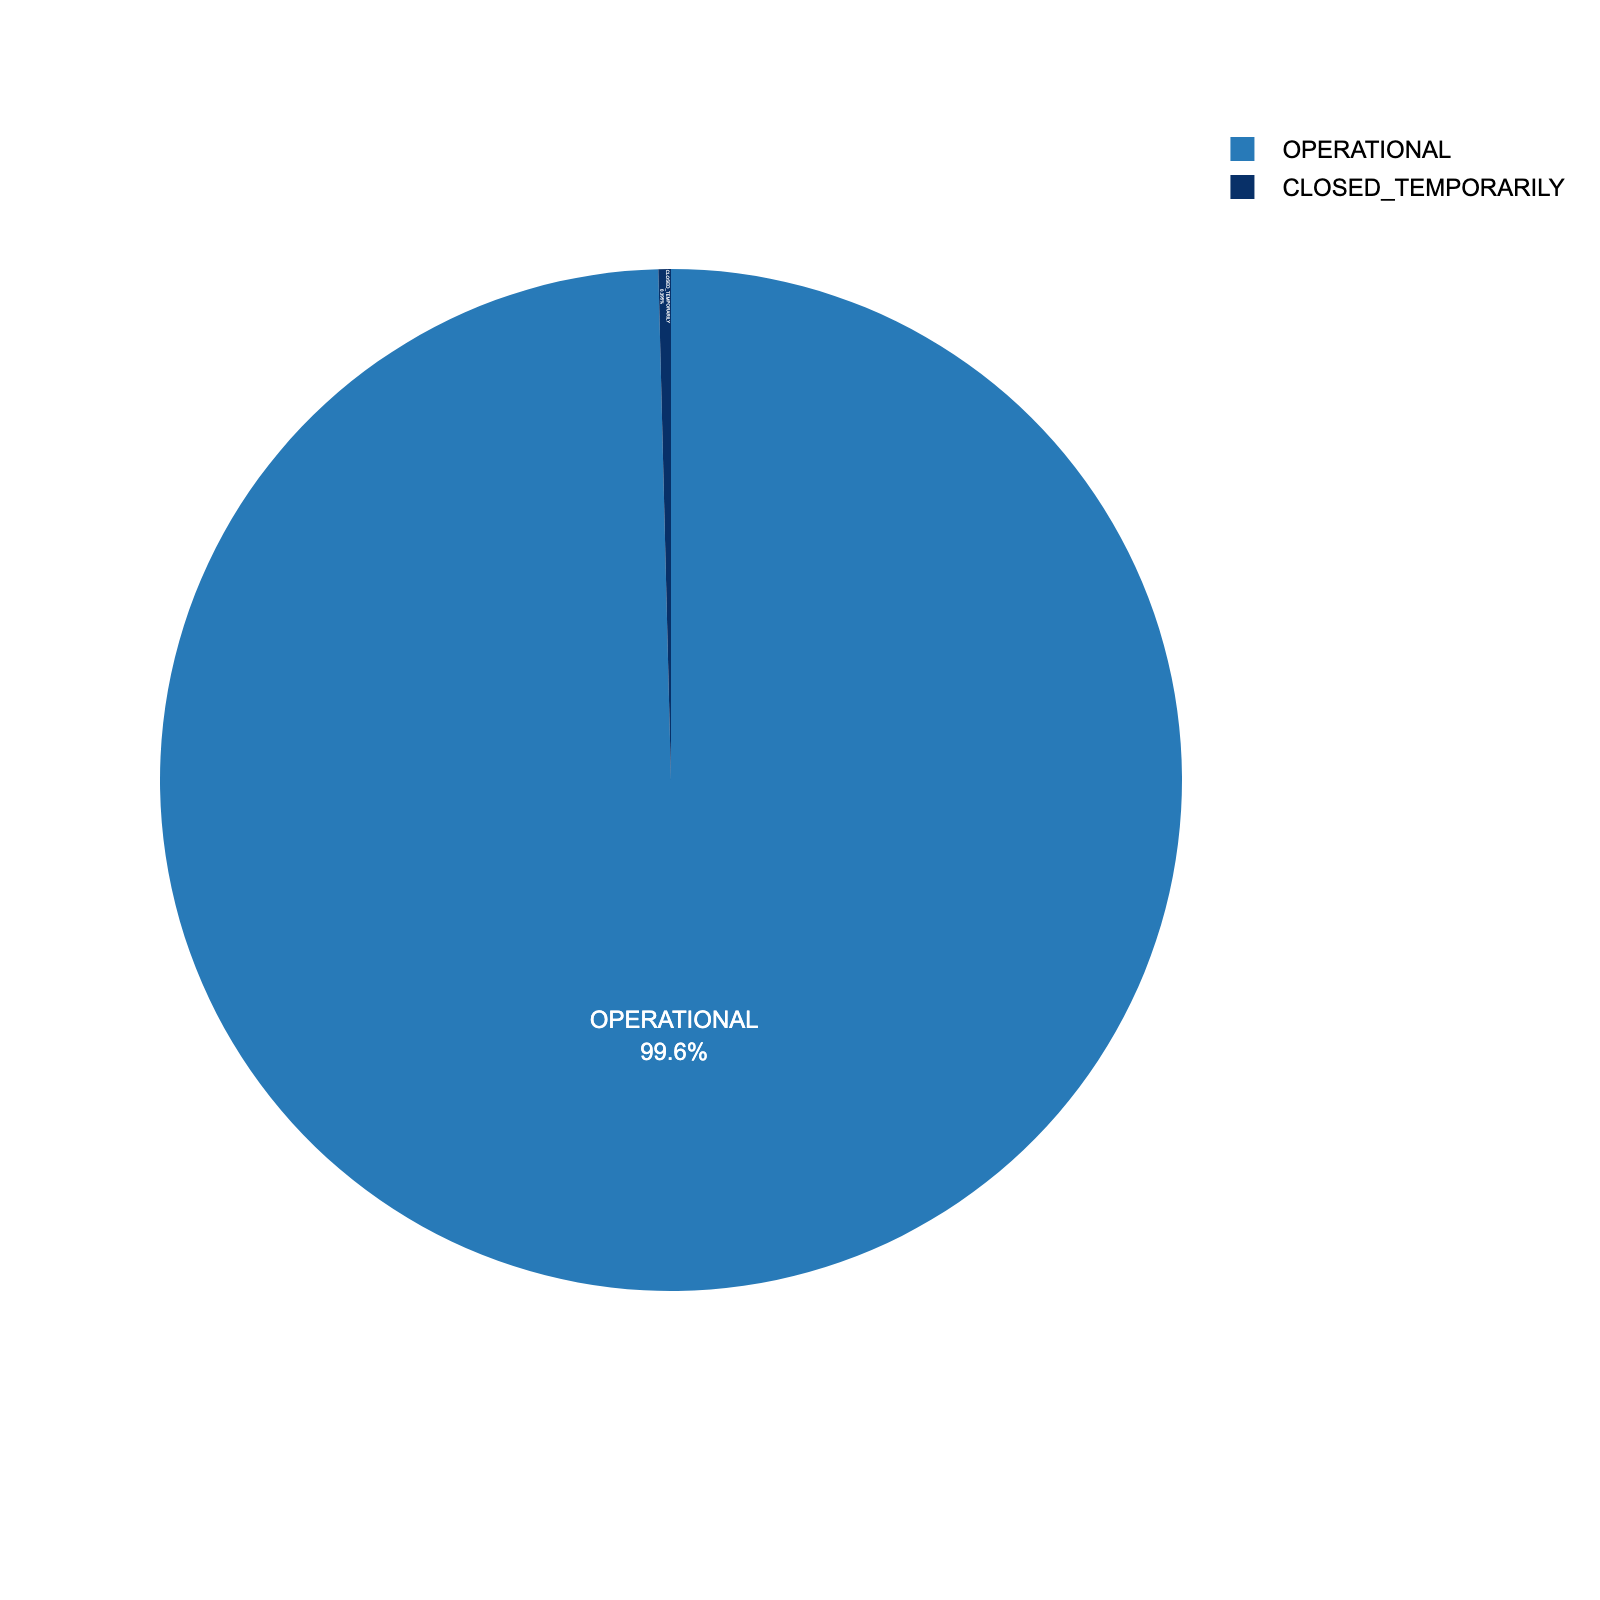

In [16]:
# Calculate business status distribution
business_status_dist = df['business_status'].value_counts()

# Plot the pie chart with Plotly
fig_pie = px.pie(
    business_status_dist,
    names=business_status_dist.index,
    values=business_status_dist.values,
    # title='Distribution of Business Status',
    color_discrete_sequence=[color_palette[10], color_palette[14]]
)

fig_pie.update_traces(textposition='inside', textinfo='percent+label')

fig_pie.update_layout(
    # title_text='Distribution of Business Status',
    title_x=0.5,
    width=800,  # Set the width of the plot
    height=800,  # Set the height of the plot
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    font=dict(
        family="Arial, sans-serif",
        size=12,
        color="#000000"
    )
)

# Show the pie chart
# fig_pie.show()

# Save the figure as a static image with transparent background
pio.write_image(fig_pie, '../plots/5_1_plot.png', scale=2, format='png', engine='kaleido')

# Optionally, display the static images
display(Image(filename='../plots/5_1_plot.png', width=800, height=600))